### Load the data and split it with a random seed of 42

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Load all CSV files from the directory
import glob
file_paths = glob.glob("Waveform/*.csv") # adjust here

# Initialize empty lists to store data
X1_list = []  # Second column
X2_list = []  # Fourth column
y_list = []   # Third column


# Read each CSV file and extract the required columns
for file_path in file_paths:
    df = pd.read_csv(file_path)

    # we will predict 2 switching cycles
    X1_list.append(df.iloc[0:201, 1])  # Second column
    X2_list.append(df.iloc[0:201, 3])  # Fourth column
    y_list.append(df.iloc[0:201, 2])   # Third column

# Convert lists to numpy arrays
X1 = np.array(X1_list)[..., None]
X2 = np.array(X2_list)[..., None]
y = np.array(y_list)[..., None]

# Combine input features    
X = np.concatenate((X1, X2), axis=2)
print(X.shape)
#np.savetxt("waveform_data.csv", X, delimiter=",")


# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)

# Second split: Split temp into validation and test (50% each of the remaining 40%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes to verify split
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

(100, 201, 2)
Training set shape: (40, 201, 2) (40, 201, 1)
Validation set shape: (30, 201, 2) (30, 201, 1)
Test set shape: (30, 201, 2) (30, 201, 1)


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

X_tesnor = torch.tensor(X_train, dtype=torch.float32)
Y_tesnor = torch.tensor(y_train, dtype=torch.float32)

dataset = TensorDataset(X_tesnor, Y_tesnor)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [4]:
class WaveformLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)  # 1 output per timestep

    def forward(self, x):
        out, _ = self.lstm(x)  # (batch, 201, 64)
        out = self.fc(out)     # (batch, 201, 1)
        return out

In [7]:
model = WaveformLSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 400
for epoch in range(epochs):
    for xb, yb in loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    print(f"Epoch {epoch+1}: Loss = {loss.item():.6f}")

Epoch 1: Loss = 21.688335
Epoch 2: Loss = 24.851902
Epoch 3: Loss = 12.140676
Epoch 4: Loss = 25.284979
Epoch 5: Loss = 19.952820
Epoch 6: Loss = 18.225334
Epoch 7: Loss = 12.495021
Epoch 8: Loss = 19.715576
Epoch 9: Loss = 15.853253
Epoch 10: Loss = 13.976265
Epoch 11: Loss = 23.165855
Epoch 12: Loss = 15.231365
Epoch 13: Loss = 16.139101
Epoch 14: Loss = 8.713440
Epoch 15: Loss = 14.438893
Epoch 16: Loss = 13.265708
Epoch 17: Loss = 10.198625
Epoch 18: Loss = 19.492720
Epoch 19: Loss = 11.191438
Epoch 20: Loss = 14.456527
Epoch 21: Loss = 12.727283
Epoch 22: Loss = 10.714296
Epoch 23: Loss = 8.639853
Epoch 24: Loss = 14.125046
Epoch 25: Loss = 7.844625
Epoch 26: Loss = 9.852438
Epoch 27: Loss = 16.339218
Epoch 28: Loss = 9.215874
Epoch 29: Loss = 8.156317
Epoch 30: Loss = 15.727449
Epoch 31: Loss = 5.623680
Epoch 32: Loss = 10.645677
Epoch 33: Loss = 8.539995
Epoch 34: Loss = 11.131509
Epoch 35: Loss = 7.548529
Epoch 36: Loss = 5.157693
Epoch 37: Loss = 7.103135
Epoch 38: Loss = 11.0

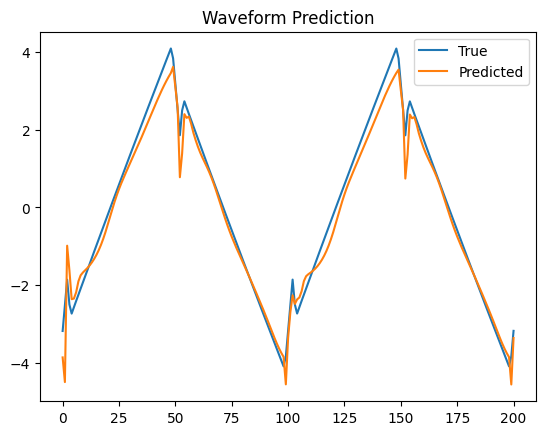

MSE: 0.3623
MAE: 0.3718
R²: 0.9859


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


model.eval()
with torch.no_grad():
    sample_input = X_tesnor[0].unsqueeze(0)  # shape: (1, 201, 2)
    pred_output = model(sample_input)        # shape: (1, 201, 1)
    y_pred = model(X_tesnor).numpy()
    y_true = Y_tesnor.numpy()

import matplotlib.pyplot as plt
plt.plot(Y_tesnor[0].squeeze(), label="True")
plt.plot(pred_output.squeeze(), label="Predicted")
plt.legend()
plt.title("Waveform Prediction")
plt.show()


mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
r2 = r2_score(y_true.flatten(), y_pred.flatten())

model.size()

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")